In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchsummary import summary
from torchmetrics import JaccardIndex

import time
import copy
import os

In [2]:
data_dir = '../datasets/camouflage_image_segmentation/Images'
mask_dir = '../datasets/camouflage_image_segmentation/Masks'

In [3]:
data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((200,200)),
        # transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'Validation': transforms.Compose([
        transforms.Resize((200,200)),
        # transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
}
mask_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((200,200)),
        transforms.Grayscale(),
        transforms.ToTensor()
    ]),
    'Validation': transforms.Compose([
        transforms.Resize((200,200)),
        transforms.Grayscale(),
        transforms.ToTensor()
    ])
}

In [4]:
class ImageMaskDataset(Dataset):
    def __init__(self, data_dir, mask_dir, train = True, transform = None, mask_transform = None) -> None:
        super(ImageMaskDataset, self).__init__()
        self.imgs = []
        self.transform = transform
        if train:
            for file1 in os.scandir(data_dir+'/Train'):
                file2 = mask_dir+'/Train/'+file1.name[:-3]+'png'
                if self.transform is not None:
                    self.imgs.append((self.transform(Image.open(file1.path).convert('RGB')),mask_transform(Image.open(file2))))
                else:
                    self.imgs.append((Image.open(file1.path).convert('RGB'),Image.open(file2)))
        else:
            for file1 in os.scandir(data_dir+'/Validation'):
                file2 = mask_dir+'/Validation/'+file1.name[:-3]+'png'
                if self.transform is not None:
                    self.imgs.append((self.transform(Image.open(file1.path).convert('RGB')),mask_transform(Image.open(file2))))
                else:
                    self.imgs.append((Image.open(file1.path).convert('RGB'),Image.open(file2)))
                    # if self.imgs[-1][0].shape[0] == 1:
                    #     self.imgs[-1] = (self.imgs[-1][0].repeat(3,1,1), self.imgs[-1][1])
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        return self.imgs[index]

In [5]:
train_data = ImageMaskDataset(data_dir, mask_dir, train = True, transform=data_transforms['Train'], mask_transform=mask_transforms['Train'])
val_data = ImageMaskDataset(data_dir, mask_dir, train = False, transform=data_transforms['Validation'], mask_transform=mask_transforms['Validation'])

In [6]:
train_loader = DataLoader(
    train_data,
    batch_size = 64,
    shuffle = True,
)
val_loader = DataLoader(
    val_data,
    batch_size = 64,
    shuffle = True,
)

In [7]:
def image_show(image, mask, pred = None):
    image = image*0.5 + 0.5
    mask = mask*0.5 + 0.5
    plt.figure(figsize=(20,10))
    if pred is not None:
        plt.subplot(1,3,1)
        plt.title('Image')
        plt.imshow(image.numpy().transpose((1,2,0)), cmap='gray')
        plt.subplot(1,3,2)
        plt.title('True Mask')
        plt.imshow(mask.numpy().transpose((1,2,0)), cmap='gray')
        plt.subplot(1,3,3)
        plt.title('Predicted Mask')
        plt.imshow(pred.detach().numpy().transpose((1,2,0)), cmap='gray')
    else:
        plt.subplot(1,3,1)
        plt.title('Image')
        plt.imshow(image.numpy().transpose((1,2,0)), cmap='gray')
        plt.subplot(1,3,2)
        plt.title('Mask')
        plt.imshow(mask.numpy().transpose((1,2,0)), cmap='gray')

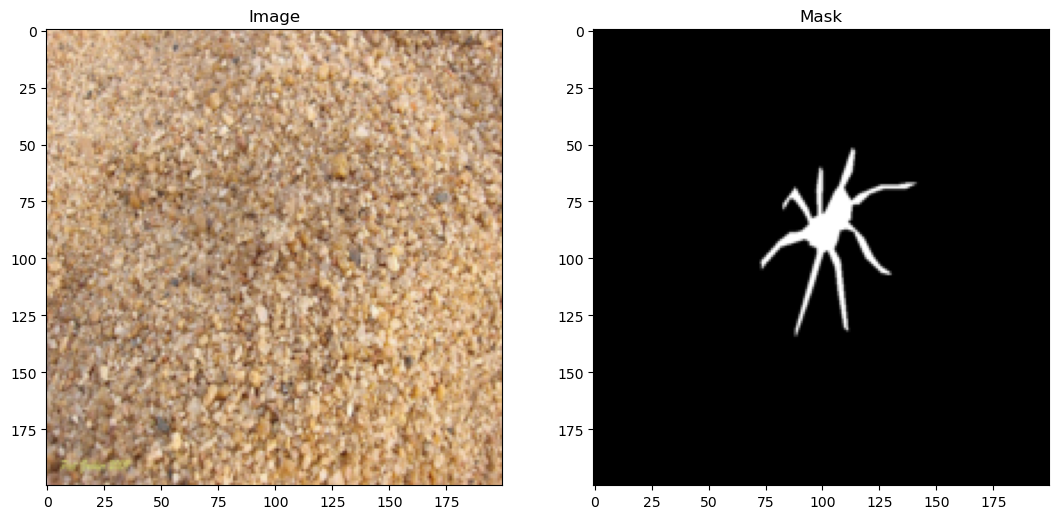

In [8]:
dataiter = iter(train_loader)
image, mask = next(dataiter)
index = 0
image_show(image[index], mask[index])

In [9]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [10]:
class UNet(nn.Module):
    def __init__(self) -> None:
        super(UNet, self).__init__()

        # ENCODER
        self.conv11 = nn.Conv2d(3, 8, 7, 1, 'same') # 200, 200, 3 --> 200, 200, 8
        self.norm11 = nn.BatchNorm2d(8)
        self.conv12 = nn.Conv2d(8, 32, 5, 1, 'same') # 200, 200, 8 --> 200, 200, 32
        self.norm12 = nn.BatchNorm2d(32)
        self.conv13 = nn.Conv2d(32, 64, 3, 1, 'same') # 200, 200, 32 --> 200, 200, 64
        self.norm13 = nn.BatchNorm2d(64)

        self.maxpool1 = nn.MaxPool2d(2,2) # 100, 100, 64

        self.conv21 = nn.Conv2d(64, 128, 7, 1, 'same') # 100, 100, 64 --> 100, 100, 128
        self.norm21 = nn.BatchNorm2d(128)
        self.conv22 = nn.Conv2d(128, 128, 5, 1, 'same') # 100, 100, 128 --> 100, 100, 128
        self.norm22 = nn.BatchNorm2d(128)
        self.conv23 = nn.Conv2d(128, 128, 3, 1, 'same') # 100, 100, 128 --> 100, 100, 128
        self.norm23 = nn.BatchNorm2d(128)

        self.maxpool2 = nn.MaxPool2d(2,2) # 50, 50, 128

        self.conv31 = nn.Conv2d(128, 256, 5, 1, 'same') # 50, 50, 128 --> 50, 50, 256
        self.norm31 = nn.BatchNorm2d(256)
        self.conv32 = nn.Conv2d(256, 256, 5, 1, 'same') # 50, 50, 256 --> 50, 50, 256
        self.norm32 = nn.BatchNorm2d(256)
        self.conv33 = nn.Conv2d(256, 256, 3, 1, 'same') # 50, 50, 256 --> 50, 50, 256
        self.norm33 = nn.BatchNorm2d(256)

        self.maxpool3 = nn.MaxPool2d(2,2) # 25, 25, 128

        self.conv41 = nn.Conv2d(256, 512, 3, 1, 1) # 25, 25, 256 --> 25, 25, 512
        self.norm41 = nn.BatchNorm2d(512)
        self.conv42 = nn.Conv2d(512, 512, 3, 1, 1) # 25, 25, 512 --> 25, 25, 512
        self.norm42 = nn.BatchNorm2d(512)
        self.conv43 = nn.Conv2d(512, 512, 3, 1, 1) # 25, 25, 512 --> 25, 25, 512
        self.norm43 = nn.BatchNorm2d(512)

        # DECODER
        self.convT1 = nn.ConvTranspose2d(512, 256, 2, 2)

        self.conv51 = nn.Conv2d(512, 512, 3, 1, 'same')
        self.norm51 = nn.BatchNorm2d(512)
        self.conv52 = nn.Conv2d(512, 512, 3, 1, 'same')
        self.norm52 = nn.BatchNorm2d(512)
        self.conv53 = nn.Conv2d(512, 512, 5, 1, 'same')
        self.norm53 = nn.BatchNorm2d(512)

        self.convT2 = nn.ConvTranspose2d(512, 128, 2, 2)

        self.conv61 = nn.Conv2d(256, 256, 3, 1, 'same')
        self.norm61 = nn.BatchNorm2d(256)
        self.conv62 = nn.Conv2d(256, 256, 5, 1, 'same')
        self.norm62 = nn.BatchNorm2d(256)
        self.conv63 = nn.Conv2d(256, 256, 5, 1, 'same')
        self.norm63 = nn.BatchNorm2d(256)

        self.convT3 = nn.ConvTranspose2d(256, 64, 2, 2)

        self.conv71 = nn.Conv2d(128, 64, 3, 1, 'same')
        self.norm71 = nn.BatchNorm2d(64)
        self.conv72 = nn.Conv2d(64, 16, 5, 1, 'same')
        self.norm72 = nn.BatchNorm2d(16)
        self.conv73 = nn.Conv2d(16, 1, 7, 1, 'same')
        self.norm73 = nn.BatchNorm2d(1)

    def forward(self, x):
        # ENCODER
        x = torch.relu(self.norm11(self.conv11(x)))
        x = torch.relu(self.norm12(self.conv12(x)))
        x_temp1 = torch.relu(self.norm13(self.conv13(x)))

        x = self.maxpool1(x_temp1)

        x = torch.relu(self.norm21(self.conv21(x)))
        x = torch.relu(self.norm22(self.conv22(x)))
        x_temp2 = torch.relu(self.norm23(self.conv23(x)))

        x = self.maxpool2(x_temp2)

        x = torch.relu(self.norm31(self.conv31(x)))
        x = torch.relu(self.norm32(self.conv32(x)))
        x_temp3 = torch.relu(self.norm33(self.conv33(x)))

        x = self.maxpool3(x_temp3)

        x = torch.relu(self.norm41(self.conv41(x)))
        x = torch.relu(self.norm42(self.conv42(x)))
        x = torch.relu(self.norm43(self.conv43(x)))

        # DECODER
        x = self.convT1(x)

        x = torch.cat((x,x_temp3), 1)

        x = torch.relu(self.norm51(self.conv51(x)))
        x = torch.relu(self.norm52(self.conv52(x)))
        x = torch.relu(self.norm53(self.conv53(x)))

        x = self.convT2(x)

        x = torch.cat((x,x_temp2), 1)

        x = torch.relu(self.norm61(self.conv61(x)))
        x = torch.relu(self.norm62(self.conv62(x)))
        x = torch.relu(self.norm63(self.conv63(x)))

        x = self.convT3(x)   

        x = torch.cat((x,x_temp1), 1)

        x = torch.relu(self.norm71(self.conv71(x)))
        x = torch.relu(self.norm72(self.conv72(x)))
        x = torch.sigmoid(self.norm73(self.conv73(x)))

        return x

In [14]:
unet = UNet().to(device)

In [15]:
summary(copy.deepcopy(unet).to('cpu'), (3, 200,200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 200, 200]           1,184
       BatchNorm2d-2          [-1, 8, 200, 200]              16
            Conv2d-3         [-1, 32, 200, 200]           6,432
       BatchNorm2d-4         [-1, 32, 200, 200]              64
            Conv2d-5         [-1, 64, 200, 200]          18,496
       BatchNorm2d-6         [-1, 64, 200, 200]             128
         MaxPool2d-7         [-1, 64, 100, 100]               0
            Conv2d-8        [-1, 128, 100, 100]         401,536
       BatchNorm2d-9        [-1, 128, 100, 100]             256
           Conv2d-10        [-1, 128, 100, 100]         409,728
      BatchNorm2d-11        [-1, 128, 100, 100]             256
           Conv2d-12        [-1, 128, 100, 100]         147,584
      BatchNorm2d-13        [-1, 128, 100, 100]             256
        MaxPool2d-14          [-1, 128,

# Adam Optimizer

In [14]:
# def soft_dice_loss(y_pred, y_true, epsilon=1e-6): 
#     axes = tuple(range(1, len(y_pred.shape)-1)) 
#     numerator = 2. * torch.sum(y_pred * y_true, axes)
#     denominator = torch.sum(torch.square(y_pred) + torch.square(y_true), axes)
#     return 1 - torch.mean((numerator + epsilon) / (denominator + epsilon)) # average over classes and batch

In [16]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=2e-1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.6)

In [19]:
num_epochs = 30
batches = len(train_loader)
losses = []

In [20]:
tic = time.time()
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs} (LR: {scheduler.get_last_lr()})')
    for i, (images,masks) in enumerate(train_loader):
        images = images.to(device)
        masks = torch.round(masks.to(device))

        preds = unet.forward(images)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'Step {i+1}/{batches}; Loss = {loss.item():.4f}')
        losses.append(loss.item())
    scheduler.step()
print('Finished Training!')
print(f'Time Taken = {(time.time() - tic)//60:.0f}m {(time.time() - tic)%60:.0f}s')

Epoch 1/30 (LR: [0.2])
Step 1/16; Loss = 0.7049
Step 2/16; Loss = 0.5886
Step 3/16; Loss = 0.5436
Step 4/16; Loss = 0.5178
Step 5/16; Loss = 0.5003
Step 6/16; Loss = 0.4766
Step 7/16; Loss = 0.4431
Step 8/16; Loss = 0.4873
Step 9/16; Loss = 0.4566
Step 10/16; Loss = 0.4127
Step 11/16; Loss = 0.4659
Step 12/16; Loss = 0.4650
Step 13/16; Loss = 0.4505
Step 14/16; Loss = 0.4554
Step 15/16; Loss = 0.4734
Step 16/16; Loss = 0.4995
Epoch 2/30 (LR: [0.12])
Step 1/16; Loss = 0.5483
Step 2/16; Loss = 0.4352
Step 3/16; Loss = 0.4619
Step 4/16; Loss = 0.5399
Step 5/16; Loss = 0.4387
Step 6/16; Loss = 0.4543
Step 7/16; Loss = 0.4541
Step 8/16; Loss = 0.4099
Step 9/16; Loss = 0.4103
Step 10/16; Loss = 0.4164
Step 11/16; Loss = 0.3845
Step 12/16; Loss = 0.3757
Step 13/16; Loss = 0.3899
Step 14/16; Loss = 0.4312
Step 15/16; Loss = 0.3686
Step 16/16; Loss = 0.4365
Epoch 3/30 (LR: [0.072])
Step 1/16; Loss = 0.4419
Step 2/16; Loss = 0.4149
Step 3/16; Loss = 0.3992
Step 4/16; Loss = 0.4140
Step 5/16; Los

Text(0.5, 1.0, 'Loss')

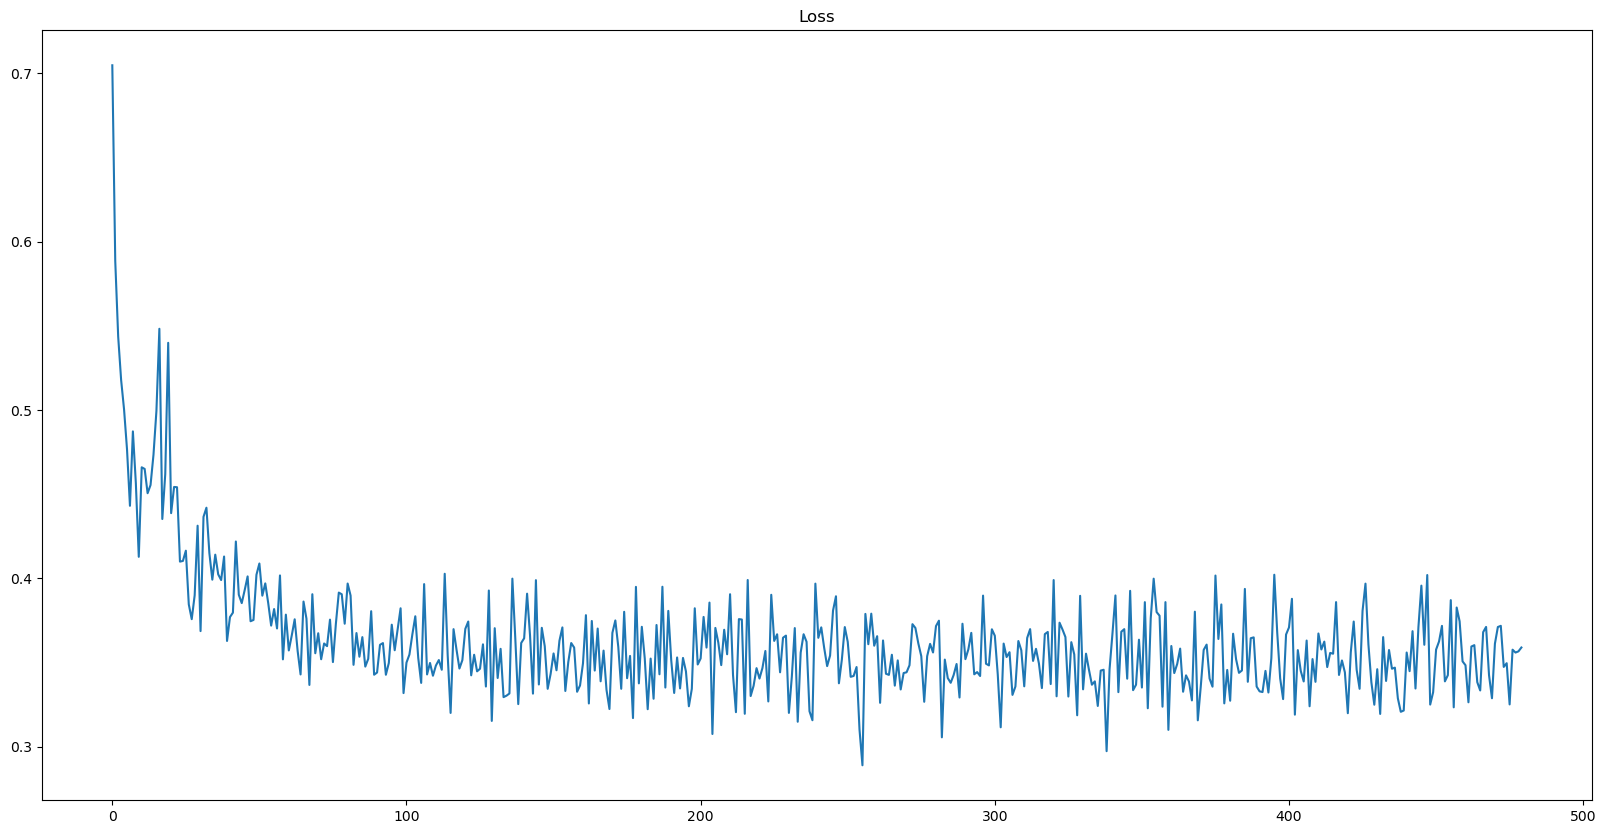

In [21]:
plt.figure(figsize=(20,10))
plt.plot(losses)
plt.title('Loss')

## Saving the model

In [22]:
# torch.save(unet, '../models/U-Net_Image_Segmentation_IE643.pt')

## Binary IoU

In [11]:
def binaryJaccardIndex(preds, masks):
    intersection = 0
    union = 0
    preds = preds.view(-1) # Reshaping to a single array
    masks = masks.view(-1) # Reshaping to a single array

    intersection = (preds * masks).sum()
    total = (preds + masks).sum()
    union = total - intersection 
    
    IoU = intersection/union
            
    return IoU

## Loading the model

In [12]:
unet = torch.load('../models/U-Net_Image_Segmentation_IE643.pt')
unet.eval()

UNet(
  (conv11): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (norm11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv12): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (norm12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv13): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv21): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (norm21): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv22): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (norm22): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv23): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), 

## Testing on train and validation set

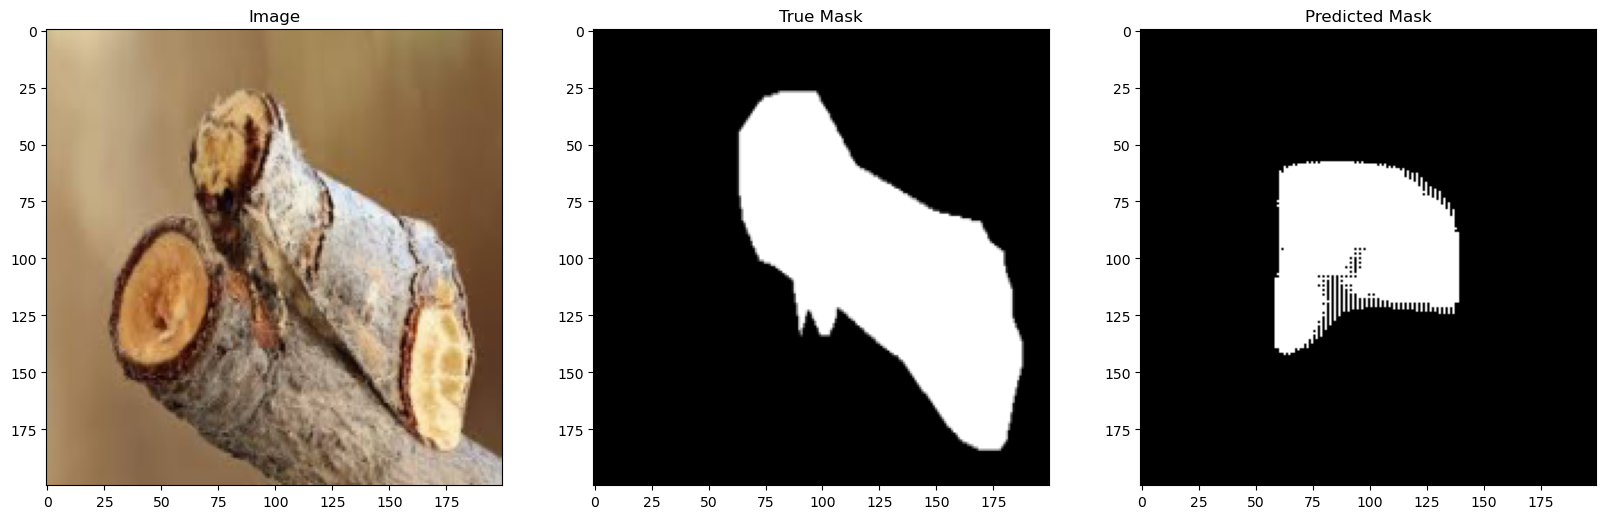

In [13]:
image, mask = next(iter(train_loader))
image = image.to(device)
mask = mask.to('cpu')
pred = unet(image).cpu()
pred1 = torch.round(pred)
image = image.to('cpu')
image_show(image[0], mask[0], pred1[0]) # Printing one of

In [16]:
IoU_value = 0
for image, mask in train_loader:
    image = image.to(device)
    mask = mask.to('cpu')
    pred = unet(image).cpu()
    pred = torch.round(pred)
    IoU_value += binaryJaccardIndex(pred, torch.round(mask).type(torch.int16)).item()
print(f'Intersection Over Union value = {IoU_value/len(train_loader)}')

Intersection Over Union value = 0.16175333876162767


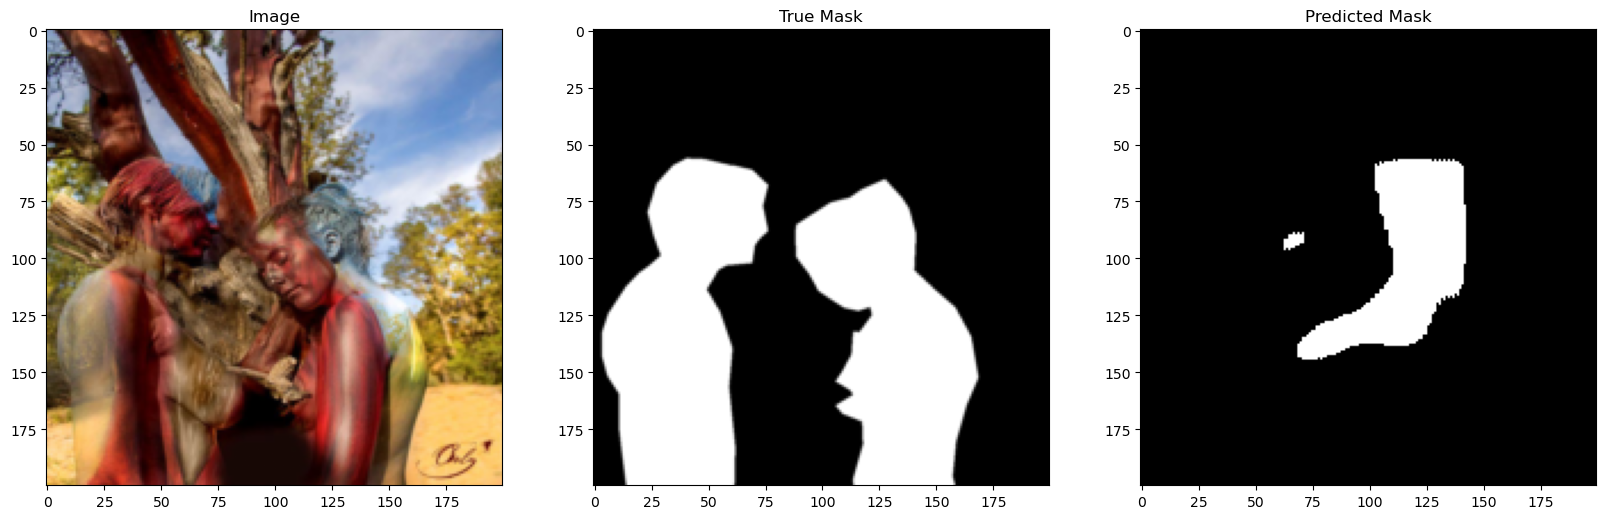

In [27]:
image, mask = next(iter(val_loader))
image = image.to(device)
mask = mask.to('cpu')
pred = unet(image).cpu()
pred1 = torch.round(pred)
image = image.to('cpu')
image_show(image[0], mask[0], pred1[0])

In [17]:
IoU_value = 0
for image, mask in val_loader:
    image = image.to(device)
    mask = mask.to('cpu')
    pred = unet(image).cpu()
    pred = torch.round(pred)
    IoU_value += binaryJaccardIndex(pred, torch.round(mask).type(torch.int16)).item()
print(f'Intersection Over Union value = {IoU_value/len(val_loader)}')

Intersection Over Union value = 0.14345664158463478
